# Comparing Solar Generation to Usage Data

In order to calculate the payback period of our solar installation, we need to first determine what it will generate.  We have solar radiation data from our weather station in watts per square meter with 5-minute resolution.  We have usage data from the utility in kilowatt-hours with 15-minute resolution.  We can use these to calculate how much solar we would have generated for a given time period in order to calculate the amount of power usage that would be offset by solar.

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import pytz

## Getting our data

We can get our solar data from our weather station.  AmbientWeather provides a csv export feature which is documented [here](https://ambientweather.com/faqs/question/view/id/1807/).  We selected a year of data for the best representation.

We can get our usage data from the utility.  The process for getting a csv of usage data is outlined in the [Green Button Download My Data](https://www.pge.com/en/save-energy-and-money/energy-usage-and-tips/understand-my-usage/energy-data-hub.html) section of [this document](https://www.pge.com/en/save-energy-and-money/energy-usage-and-tips/understand-my-usage/energy-data-hub.html).

In [2]:
solar_data = pd.read_csv('../data/raw/Solar ROI - ambient-weather-20230203-20240130.csv')
usage_data = pd.read_csv('../data/raw/Solar ROI - pge_electric_interval_data_0627600496_2023-01-30_to_2024-01-30.csv')

We need to normalize the times and dates in our datasets.  Our solar data is in UTC and the `date` column is a complete timestamp.  Each record in solar data is a measurement at that point in time.

On the other hand, the usage data is already in local time, but each record represents a time window.  The column `date` represents the year-month-day and `start_time` and `end_time` represent the start and end of the time window, expressed in 24-hour clock without leading zeroes.

In [3]:
# Convert all column names to lowercase in the usage dataset
usage_data.columns = usage_data.columns.str.lower().str.replace(' ', '_')

# Convert the 'date' column in both datasets to datetime objects and localize to America/Los_Angeles timezone
solar_data['Date'] = pd.to_datetime(solar_data['Date'], utc=True, errors='coerce').dt.tz_convert('America/Los_Angeles')
usage_data['date'] = pd.to_datetime(usage_data['date'], errors='coerce').dt.tz_localize('America/Los_Angeles', ambiguous='NaT')

# Convert the 'start_time' and 'end_time' columns to datetime objects
usage_data['start_time'] = pd.to_datetime(usage_data['start_time'], format='%H:%M').dt.time
usage_data['end_time'] = pd.to_datetime(usage_data['end_time'], format='%H:%M').dt.time

## Calculating Solar Generation

Now we have solar generation for points in time expressed in watts per square meter and we have usage in 15 minute time windows expressed in kilowatt hours.  We need to calculate how much solar energy we would generate in each 15 minute window.  We'll start by averaging the generation using all solar datapoints within the usage time window.  Of course, we don't get to use all of that radiation, so we'll apply some coefficients.  The solar panels we're considering are 20.3% efficient.  The rest of the system (inverter, optimizers, etc) are about 95% efficent.  We'll need to adjust for that.  We then need the total area of the photovoltaic cells.  Each panel is about 1.97 square meters large.  We'll have 16 panels, so we use 31.52 square meters as our area.

Using these coefficients, we can calculate the amount of energy generated in each time window and add that to our usage data.  Once we have that, we can calculate our offsets.

We calculate the adjusted usage by subtracting the solar generation from the original usage. If the result is negative (i.e., the solar generation is greater than the usage), we set it to zero. This ensures that we don't have negative adjusted usage.

We calculate the remaining solar generation that can be sold to the grid by subtracting the adjusted usage from the solar generation. If the result is negative (i.e., the adjusted usage is greater than the solar generation), we set it to zero. This ensures that we don't have negative grid sell values.

In [5]:
solar_panel_efficiency = 0.203
system_efficiency = 0.95
solar_panel_surface_area = 31.52  # in square meters

def calculate_solar_generated(row):
    relevant_solar_data = solar_data[
        (solar_data['Date'].dt.date == row['date'].date()) &
        (solar_data['Date'].dt.time >= row['start_time']) &
        (solar_data['Date'].dt.time <= row['end_time'])
    ]
    
    average_solar_radiation = relevant_solar_data['Solar Radiation (W/m^2)'].mean()
    usage_duration_hours = (pd.to_datetime(row['end_time'].strftime('%H:%M:%S')) - pd.to_datetime(row['start_time'].strftime('%H:%M:%S'))).seconds / 3600
    
    # Adjusted solar_generated with efficiency considerations and surface area
    solar_generated = average_solar_radiation * solar_panel_efficiency * system_efficiency * solar_panel_surface_area * usage_duration_hours
    
    return solar_generated / 1000  # Convert from Wh to kWh

# Apply the function to create the 'solar_generated' column with tqdm_notebook for progress bar
tqdm.pandas()
usage_data['solar_generated'] = usage_data.progress_apply(calculate_solar_generated, axis=1)

# Calculate usage_adjusted and grid_sell columns
usage_data['usage_adjusted'] = usage_data.apply(lambda row: max(row['usage'] - row['solar_generated'], 0), axis=1)
usage_data['grid_sell'] = usage_data.apply(lambda row: max(row['solar_generated'] - row['usage_adjusted'], 0), axis=1)

# Save our progress
usage_data.to_csv('../data/processed/Solar ROI - usage_data_with_generation.csv')

  0%|          | 0/35136 [00:00<?, ?it/s]

## Analysis

What conclusions can we make so far?  We can only make conclusions about usage because we don't have the complex rate tariffs to calculate differences in billing.  THat will come next.  For now let's answer a few questions about generation versus usage.

How much grid use would we have offset with solar?  How much could we have sold back to the grid?  Since peak usage (16:00-21:00) is more expensive, how much peak usage would have been offset?

In [6]:
# Calculate total solar generation, total adjusted usage, and percent reduction
total_solar_generated = usage_data['solar_generated'].sum()
total_adjusted_usage = usage_data['usage_adjusted'].sum()
percent_reduction = (total_adjusted_usage / total_solar_generated) * 100

# Calculate peak usage and peak offset
peak_usage = usage_data[(usage_data['start_time'].apply(lambda x: x.hour) >= 16) & (usage_data['end_time'].apply(lambda x: x.hour) <= 21)]['usage'].sum()
peak_offset = usage_data[(usage_data['start_time'].apply(lambda x: x.hour) >= 16) & (usage_data['end_time'].apply(lambda x: x.hour) <= 21)]['usage_adjusted'].sum()
percent_peak_offset = (peak_offset / peak_usage) * 100 if peak_usage > 0 else 0

# Calculate total kWh sold back to the grid
usage_data['grid_sell'] = usage_data.apply(lambda row: max(row['solar_generated'] - row['usage_adjusted'], 0), axis=1)
total_grid_sell = usage_data['grid_sell'].sum()

# Print the result
print(f'Total kWh Sold Back to the Grid: {total_grid_sell:.2f} kWh')

print(f'Total Solar Generation: {total_solar_generated:.2f} kWh')
print(f'Total Adjusted Usage: {total_adjusted_usage:.2f} kWh')
print(f'Percent Reduction: {percent_reduction:.2f}%')

print(f'Peak Usage: {peak_usage:.2f} kWh')
print(f'Peak Offset: {peak_offset:.2f} kWh')
print(f'Percent Peak Offset: {percent_peak_offset:.2f}%')

Total kWh Sold Back to the Grid: 6955.13 kWh
Total Solar Generation: 7385.22 kWh
Total Adjusted Usage: 4090.47 kWh
Percent Reduction: 55.39%
Peak Usage: 1782.60 kWh
Peak Offset: 1299.63 kWh
Percent Peak Offset: 72.91%


Let's visualize it.  We'll create a visualization that should effectively communicate the idea of how much energy we would have used and how much solar generation contributes to offsetting that usage each month.

/var/folders/vn/b2b_gx7s0_g6gkr8x5wnw9600000gn/T/ipykernel_6441/1388644351.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_data['month_year'] = pd.to_datetime(filtered_data['date']).dt.to_period('M')


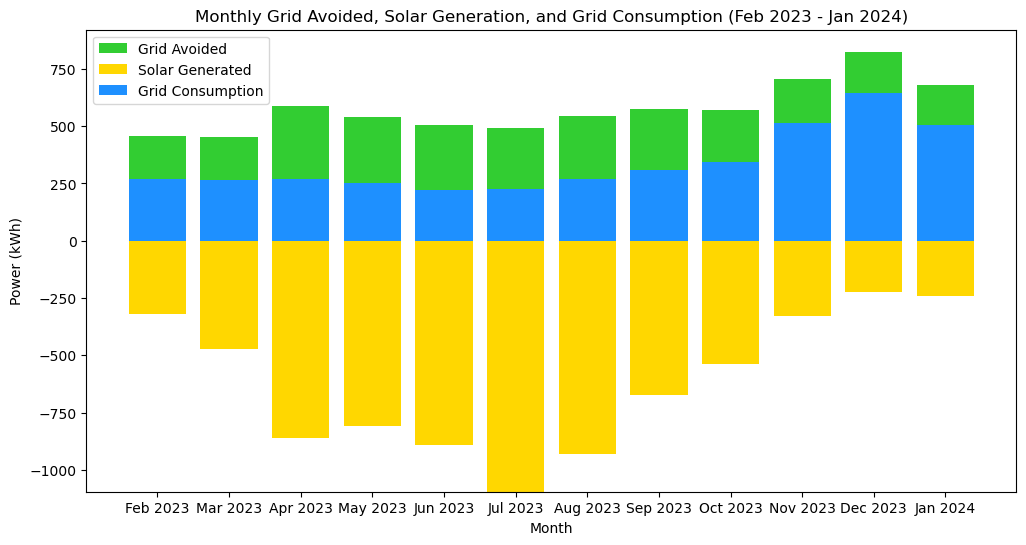

In [16]:
filtered_data = usage_data[
    (pd.to_datetime(usage_data['date']) >= '2023-02-01') &
    (pd.to_datetime(usage_data['date']) < '2024-02-01')
].copy()

# Create 'month_year' column in filtered_data
filtered_data['month_year'] = pd.to_datetime(filtered_data['date']).dt.to_period('M')

# Group filtered data by month and sum the usage, solar_generated, and usage_adjusted values
monthly_data = filtered_data.groupby('month_year').agg({'usage': 'sum', 'solar_generated': 'sum', 'usage_adjusted': 'sum'}).reset_index()

# Calculate the offset (negative solar_generated)
monthly_data['offset'] = -1 * monthly_data['solar_generated']

# Plot a stacked bar chart
plt.figure(figsize=(12, 6))
plt.bar(monthly_data['month_year'].dt.strftime('%b %Y'), monthly_data['usage'], label='Grid Avoided', color='limegreen')
plt.bar(monthly_data['month_year'].dt.strftime('%b %Y'), monthly_data['solar_generated'], label='Solar Generated', color='gold', bottom=monthly_data['offset'])
plt.bar(monthly_data['month_year'].dt.strftime('%b %Y'), monthly_data['usage_adjusted'], label='Grid Consumption', color='dodgerblue')

plt.title('Monthly Grid Avoided, Solar Generation, and Grid Consumption (Feb 2023 - Jan 2024)')
plt.xlabel('Month')
plt.ylabel('Power (kWh)')
plt.legend()
plt.show()


Next, we'll talk about cost savings in [02-bill-calculation-notebook.ipynb](./02-bill-calculation-notebook.ipynb)